<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
from scipy.stats import norm, sem, stats

import pylab as plt
import seaborn as sns

In [2]:
# datos
df=pd.read_csv(r"C:\Users\alexd\Ironhack\Labs\6.4_lab-AB-Testing\data\cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
sum(df.sum_gamerounds[df.sum_gamerounds<30].value_counts())

56920

In [4]:
# transformacion
ret_1 = pd.crosstab(df.version, df.retention_1)

ret_2 = pd.crosstab(df.version, df.retention_7)


In [5]:
# muestreo
ret_1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [6]:
control_ret1 = df[df.version=='gate_30'].sample(n=20030)
tratamiento_ret1= df[df.version=='gate_40'].sample(n=20030)
ab_test_1=pd.concat([control_ret1, tratamiento_ret1], axis=0)
ab_test_1.head()

,userid,version,sum_gamerounds,retention_1,retention_7
84722,9392958,gate_30,30,True,False
41939,4636538,gate_30,5,False,False
38029,4208544,gate_30,12,True,False
12270,1359013,gate_30,17,False,False
80648,8930330,gate_30,21,False,False


In [7]:
tasas_conversion=ab_test_1.groupby('version')['retention_1'] 

std=lambda x: np.std(x, ddof=0)  

error_std=lambda x: stats.sem(x, ddof=0)  

tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.446,0.497,0.004
gate_40,0.444,0.497,0.004


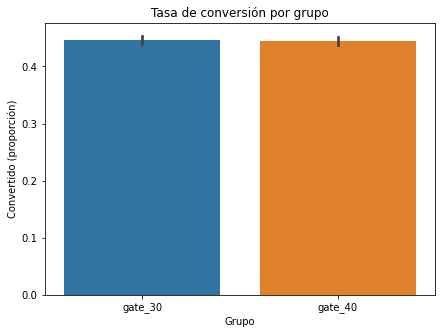

In [8]:
plt.figure(figsize=(7,5))

sns.barplot(x=ab_test_1['version'], 
            y=ab_test_1['retention_1'])

# plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [9]:
# testeo para retention_1

control_res_1=ab_test_1[ab_test_1.version=='gate_30']['retention_1']

tratamiento_res_1=ab_test_1[ab_test_1.version=='gate_40']['retention_1']


In [15]:
obs_1=[20034, 20034] 

conv_1=[control_res_1.sum(), tratamiento_res_1.sum()]

print(conv_1)
z_score, p_valor = proportions_ztest(conv_1, nobs=obs_1)
print(z_score)


(control_a, tratamiento_a), (control_b, tratamiento_b)  = proportion_confint(conv_1,  nobs=obs_1, alpha=0.05)

[8939, 8896]
0.4322467109236661


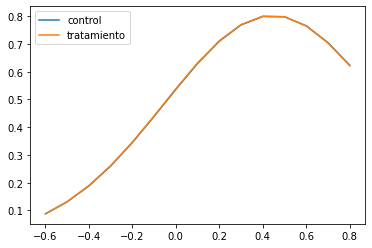

In [17]:
x=[i*.1 for i in range(-6, 9)]  

control_1=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento_1=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control_1)
plt.plot(x, tratamiento_1)
plt.legend(['control', 'tratamiento']);

In [19]:
# testeo para retention_7
ret_2

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [23]:
control_ret2 = df[df.version=='gate_30'].sample(n=8279)
tratamiento_ret2= df[df.version=='gate_40'].sample(n=8279)
ab_test_2=pd.concat([control_ret2, tratamiento_ret2], axis=0)
ab_test_2.head()

,userid,version,sum_gamerounds,retention_1,retention_7
919,102540,gate_30,249,True,True
5121,567002,gate_30,3,True,False
76765,8500618,gate_30,292,True,True
72525,8035979,gate_30,5,False,False
78359,8677832,gate_30,34,False,False


In [30]:
tasas_conv_2=ab_test_2.groupby('version')['retention_7']

std_2=lambda x: np.std(x, ddof=0)

error_std_2=lambda x: stats.sem(x, ddof=0)

tasas_conv_2=tasas_conv_2.agg([np.mean, std, error_std])
tasas_conv_2.columns=['conversion_rate', 'std', 'std_error']


tasas_conv_2.style.format('{:.2f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.19,0.40,0.00
gate_40,0.19,0.39,0.00


In [32]:
control_res_2=ab_test_2[ab_test_2.version=='gate_30']['retention_7']

tratamiento_res_2=ab_test_2[ab_test_2.version=='gate_40']['retention_7']

In [34]:
obs_2=[8279, 8279] 

conv_2=[control_res_2.sum(), tratamiento_res_2.sum()]

print(conv_2)
z_score, p_valor = proportions_ztest(conv_2, nobs=obs_2)
print(z_score)


(control_a, tratamiento_a), (control_b, tratamiento_b)  = proportion_confint(conv_2,  nobs=obs_2, alpha=0.05)

[1606, 1552]
1.0681671972703866


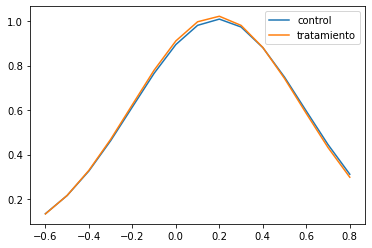

In [35]:
x=[i*.1 for i in range(-6, 9)]  

control_2=[norm.pdf(x, tasas_conv_2.iloc[0][0], tasas_conv_2.iloc[0][1]) for x in x] 

tratamiento_2=[norm.pdf(x, tasas_conv_2.iloc[1][0], tasas_conv_2.iloc[1][1]) for x in x] 

plt.plot(x, control_2)
plt.plot(x, tratamiento_2)
plt.legend(['control', 'tratamiento']);